####Importar librerias

In [ ]:
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

#path = "/tmp/images"
#os.mkdir(path)

Mounted at /content/drive


In [ ]:
%cd content/drive/MyDrive/

#####Funciones auxiliares

In [ ]:
# defining global variable path
# Location of my dataset on My Google Drive
#image_path = "drive/My Drive/Proyectos/Reconocimiento_Bicicleta/Dataset/bike"
image_path = "drive/MyDrive/Proyectos/Reconocimiento Bicicleta/Dataset/bike"

def loadImages(path):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
    image_files = sorted([os.path.join(path, 'train', file)
                          for file in os.listdir(path + "/train")
                          if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.bmp')]) 
    
    return image_files

def loadImagesTest(path):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
    image_files = sorted([os.path.join(path, 'test', file)
                          for file in os.listdir(path + "/test")
                          if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.bmp')]) 
    

def loadImagesPredict(path):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
    image_files = sorted([os.path.join(path, 'predict', file)
                          for file in os.listdir(path + "/predict")
                          if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.bmp')]) 
    
    return image_files

# Mostrar dos imagenes
def display(a, b, title1 = "Shaped", title2="GrayScale"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b, cmap='gray'), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Mostrar una imagen
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Mostrar una imagen
def display_one_gray(a, title1 = "Gray Scale"):
    plt.imshow(a, cmap='gray', vmin=0, vmax=255), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

    

# Preprocessing
def processing(data):
    
    # Reading 3 images to work
    img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in data[:3]]
    try:
        print('Original size',img[0].shape)
    except AttributeError:
        print("shape not found")
   
    # --------------------------------
    # setting dim of the resize
    height = 220
    width = 220
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    try:
        print('RESIZED', res_img[1].shape)
    except AttributeError:
        print("shape not found")
    
    
    # Visualizing one of the images in the array
    original = res_img[1]
    display_one(original)
    # ----------------------------------
    # Remove noise
    # Using Gaussian Blur
    no_noise = []
    for i in range(len(res_img)):
        blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
        no_noise.append(blur)


    image = no_noise[1]
    display(original, image, 'Original', 'Blured')
    #---------------------------------
    # Segmentation
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Displaying segmented images
    display(original, thresh, 'Original', 'Segmented')
    # Further noise removal (Morphology)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    #Displaying segmented back ground
    display(original, sure_bg, 'Original', 'Segmented Background')

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]

    # Displaying markers on the image
    display(original, markers, 'Original', 'Marked')

#####Lectura del dataset

In [ ]:
#Lectura del dataset

global image_path
'''The var Dataset is a list with all images in the folder '''
dataset = loadImages(image_path)
print('Numero de imagenes para entrenamiento:', len(dataset))
print("--------------------------------")


Numero de imagenes para entrenamiento: 473
--------------------------------


#####Lectura del dataset testing

In [ ]:
#Lectura del dataset

global image_path
#Lectura de dataset de testing
dataset_test = loadImagesTest(image_path_test)
print('Numero de imagenes para testing:', len(dataset_test))
print("--------------------------------")


Numero de imagenes para testing: 257
--------------------------------


#####Tratamiento de imagenes de entrenamiento

In [ ]:
# Reading images to work
img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in dataset]
try:
  print('Tamaño original',img[0].shape)
except AttributeError:
  print("shape not found")
# --------------------------------
# setting dim of the resize
height = 200
width = 200
dim = (width, height)
res_img = []
for i in range(len(img)):
  res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
  res_img.append(res)
# Checcking the size
try:
  print('Formateado:', res_img[1].shape)
except AttributeError:
  print("shape not found")


Tamaño original (640, 640, 3)
Formateado: (200, 200, 3)



 Transformación de la imagen: 



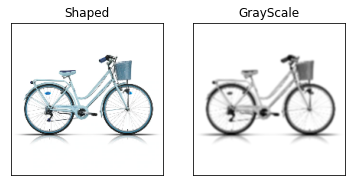


 Transformación de la imagen: 



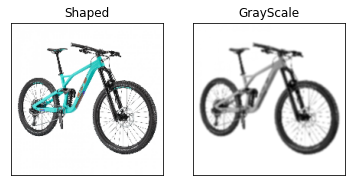


 Transformación de la imagen: 



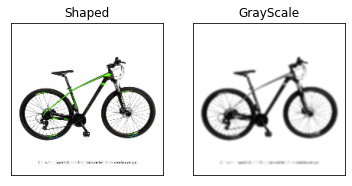


 Transformación de la imagen: 



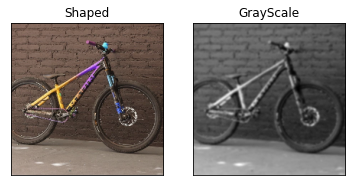


 Transformación de la imagen: 



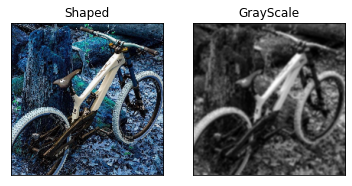


 Transformación de la imagen: 



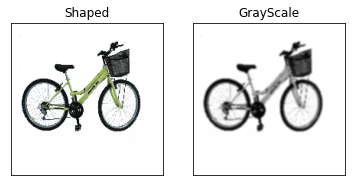


 Transformación de la imagen: 



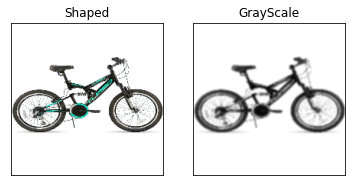


 Transformación de la imagen: 



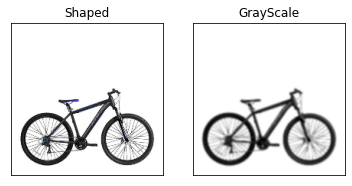


 Transformación de la imagen: 



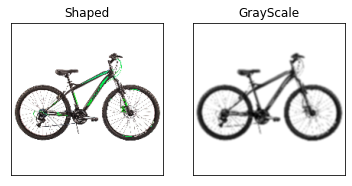


 Transformación de la imagen: 



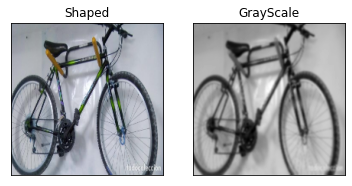

In [ ]:
#Visualizacion de las 10 primeras imagenes del dataset
for i in range(len(dataset[:10])):
    
  # ----------------------------------
  # Remove noise
  # Using Gaussian Blur
  no_noise = []
  for j in range(len(res_img)):
    blur = cv2.GaussianBlur(res_img[j], (5, 5), 0)
    no_noise.append(blur)

  gray_color = []
  for g in range(len(no_noise)):
     gray = cv2.cvtColor(no_noise[g], cv2.COLOR_RGB2GRAY)
     gray_color.append(gray)

  print('\n Transformación de la imagen: \n')
  reshape = res_img[i]
  image = no_noise[i]
  gray_image = gray_color[i]

  display(reshape, gray_image)

 

In [ ]:
#Traspaso de data a gray_color
x_train = gray_color
y_train = []
for i in range(len(x_train)):
  bike = 1
  y_train.append(bike)

x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train.flatten()
x_train = x_train.reshape(-1, 200, 200, 1)

print('Forma de array imagenes: {}'.format(x_train.shape))
print('Forma de array label: {}'.format(y_train.shape))

Forma de array imagenes: (473, 200, 200, 1)
Forma de array label: (473,)


######Tratamiento de imagenes para testing

In [ ]:
# Reading images to work
img_test = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in dataset_test]
try:
  print('Tamaño original',img_test[0].shape)
except AttributeError:
  print("shape not found")
# --------------------------------
# setting dim of the resize
height = 200
width = 200
dim = (width, height)
res_img = []
for i in range(len(img_test)):
  res = cv2.resize(img_test[i], dim, interpolation=cv2.INTER_LINEAR)
  res_img.append(res)
# Checcking the size
try:
  print('Formateado:', res_img[1].shape)
except AttributeError:
  print("shape not found")

Tamaño original (480, 640, 3)
Formateado: (200, 200, 3)



 Transformación de la imagen: 



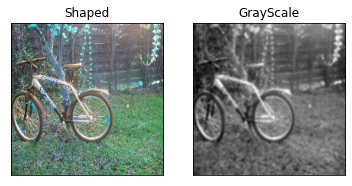


 Transformación de la imagen: 



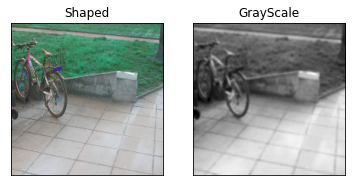


 Transformación de la imagen: 



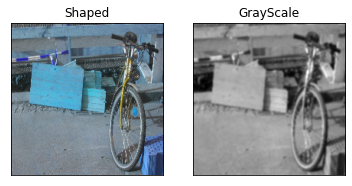


 Transformación de la imagen: 



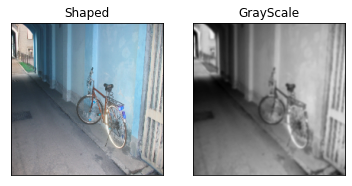


 Transformación de la imagen: 



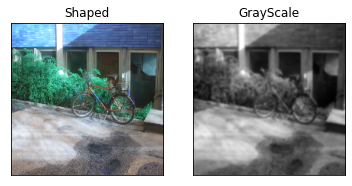


 Transformación de la imagen: 



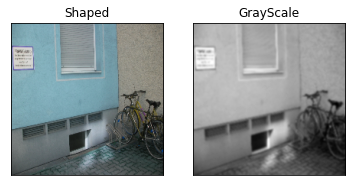


 Transformación de la imagen: 



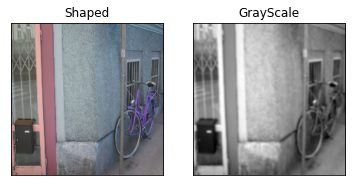


 Transformación de la imagen: 



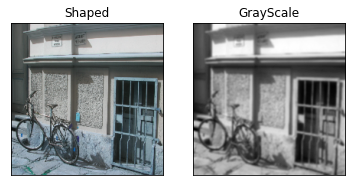


 Transformación de la imagen: 



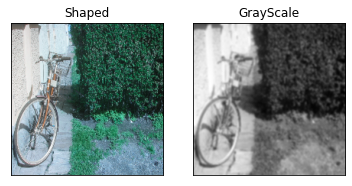


 Transformación de la imagen: 



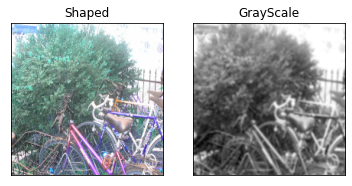

In [ ]:
#Visualizacion de las 10 primeras imagenes del dataset
for i in range(len(dataset_test[:10])):
    
  # ----------------------------------
  # Remove noise
  # Using Gaussian Blur
  no_noise = []
  for j in range(len(res_img)):
    blur = cv2.GaussianBlur(res_img[j], (5, 5), 0)
    no_noise.append(blur)

  gray_color = []
  for g in range(len(no_noise)):
     gray = cv2.cvtColor(no_noise[g], cv2.COLOR_RGB2GRAY)
     gray_color.append(gray)

  print('\n Transformación de la imagen: \n')
  reshape = res_img[i]
  image = no_noise[i]
  gray_image = gray_color[i]

  display(reshape, gray_image)


In [ ]:
#Traspaso de data a gray_color
x_test = gray_color
x_test = np.array(x_test)
x_test = x_test.reshape(-1, 200, 200, 1)

y_test = []
for i in range(len(x_test)):
  bike = 1
  y_test.append(bike)

y_test = np.array(y_test)
y_test = y_test.flatten()

print('Forma de array imagenes: {}'.format(x_test.shape))
print('Forma de array imagenes: {}'.format(y_test.shape))


Forma de array imagenes: (257, 200, 200, 1)
Forma de array imagenes: (257,)


In [ ]:
K = 1

In [ ]:
# Build the model using the functional API
i = Input(shape=x_model[0].shape)
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

# x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)



model = Model(i, x)

In [ ]:
# Compile
# Note: make sure you are using the GPU for this!
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fit
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
15/15 [==============================] - 3s 163ms/step - loss: 4.4081 - accuracy: 0.7883 - val_loss: 3.2302 - val_accuracy: 0.9300
Epoch 2/10
15/15 [==============================] - 2s 148ms/step - loss: 0.0601 - accuracy: 1.0000 - val_loss: 3.0970 - val_accuracy: 0.1128
Epoch 3/10
15/15 [==============================] - 2s 148ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 2.2988 - val_accuracy: 0.3346
Epoch 4/10
15/15 [==============================] - 2s 147ms/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 1.3854 - val_accuracy: 0.7471
Epoch 5/10
15/15 [==============================] - 2s 147ms/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 0.6007 - val_accuracy: 0.9689
Epoch 6/10
15/15 [==============================] - 2s 148ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.2926 - val_accuracy: 0.9844
Epoch 7/10
15/15 [==============================] - 2s 149ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch 

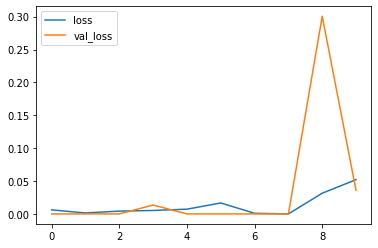

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

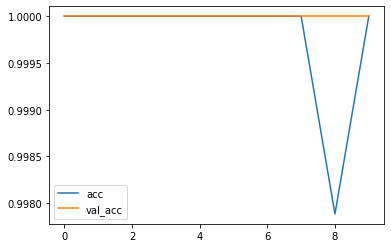

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

#####Prueba para predecir

In [ ]:
#Lectura del dataset

global image_path_test
#Lectura de dataset de testing
dataset_predict = loadImagesPredict(image_path)
print('Numero de imagenes para testing:', len(dataset_predict))
print("--------------------------------")


Numero de imagenes para testing: 4
--------------------------------


In [ ]:
# Reading images to work
img_test = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in dataset_predict]
try:
  print('Tamaño original',img_test[0].shape)
except AttributeError:
  print("shape not found")
# --------------------------------
# setting dim of the resize
height = 200
width = 200
dim = (width, height)
res_img = []
for i in range(len(img_test)):
  res = cv2.resize(img_test[i], dim, interpolation=cv2.INTER_LINEAR)
  res_img.append(res)
# Checcking the size
try:
  print('Formateado:', res_img[1].shape)
except AttributeError:
  print("shape not found")

Tamaño original (555, 750, 3)
Formateado: (200, 200, 3)



 Transformación de la imagen: 



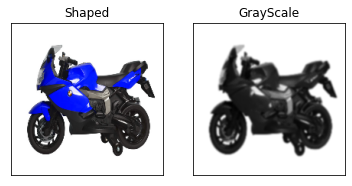


 Transformación de la imagen: 



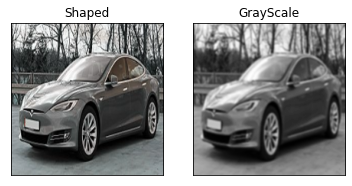


 Transformación de la imagen: 



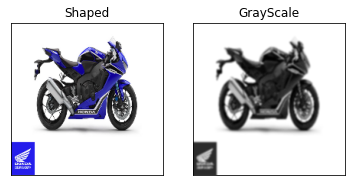


 Transformación de la imagen: 



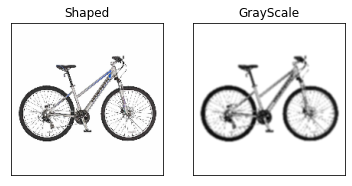

In [ ]:
#Visualizacion de las 10 primeras imagenes del dataset
for i in range(len(dataset_predict[:10])):
    
  # ----------------------------------
  # Remove noise
  # Using Gaussian Blur
  no_noise = []
  for j in range(len(res_img)):
    blur = cv2.GaussianBlur(res_img[j], (5, 5), 0)
    no_noise.append(blur)

  gray_color = []
  for g in range(len(no_noise)):
     gray = cv2.cvtColor(no_noise[g], cv2.COLOR_RGB2GRAY)
     gray_color.append(gray)

  print('\n Transformación de la imagen: \n')
  reshape = res_img[i]
  image = no_noise[i]
  gray_image = gray_color[i]

  display(reshape, gray_image)


In [ ]:
#Traspaso de data a gray_color
x_pred = gray_color
x_pred = np.array(x_pred)
x_pred = x_pred.reshape(-1, 200, 200, 1)

print('Forma de array imagenes: {}'.format(x_pred.shape))



Forma de array imagenes: (4, 200, 200, 1)


In [ ]:
preds = np.argmax(model.predict(x_pred), axis=-1)

In [ ]:
preds

array([1, 1, 1, 1])